Khai báo thư viện

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [4]:
# Đọc file 
train_data = pd.read_csv('data/train/data_train1.csv')
test_data = pd.read_csv('data/train/data_test1.csv')


In [5]:
# Separate target from predictors
y_train = train_data["Giá"]
X_train = train_data.drop(['Giá'], axis=1)
y_test = test_data['Giá']
X_test = test_data.drop(['Giá'], axis=1)

In [6]:
X_train.shape

(20776, 17)

Thực hiện mã hóa một lần cho tất cả các tính năng phân loại 

In [7]:
# Identify categorical columns
categorical_cols = [col_name for col_name in X_train.columns if X_train[col_name].dtype in ['object']]

In [8]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
OH_X_train = OH_encoder.fit_transform(X_train[categorical_cols])
OH_X_test = OH_encoder.transform(X_test[categorical_cols])

In [9]:
OH_X_train.shape

(20776, 1574)

In [10]:
# One-hot encoding removed index; put it back
OH_X_train.index = X_train.index
OH_X_test.index = X_test.index

In [11]:
# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_test = X_test.drop(categorical_cols, axis=1)

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
num_X_train_scaled = pd.DataFrame(scaler.fit_transform(num_X_train), columns=num_X_train.columns)

# Transform the test data
num_X_test_scaled = pd.DataFrame(scaler.transform(num_X_test), columns=num_X_test.columns)


In [13]:
# Chuyển đổi ma trận CSR thành DataFrame
OH_X_train_df = pd.DataFrame.sparse.from_spmatrix(OH_X_train)
OH_X_test_df = pd.DataFrame.sparse.from_spmatrix(OH_X_test)

# Kết hợp dữ liệu
X_train_concat = pd.concat([num_X_train_scaled, OH_X_train_df], axis=1)
X_test_concat = pd.concat([num_X_test_scaled, OH_X_test_df], axis=1)


In [14]:
X_train_concat.shape

(20776, 1580)

## Linear regression

In [15]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Convert all column names to string
X_train_concat.columns = X_train_concat.columns.astype(str)
X_test_concat.columns = X_test_concat.columns.astype(str)

# Define the alphas for the grid search
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]

# Train the model with cross-validated grid search on the alphas
model = RidgeCV(alphas=alphas, store_cv_values=True)
model.fit(X_train_concat, y_train)

# Make predictions
y_pred = model.predict(X_test_concat)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:2057: RuntimeWarning: divide by zero encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2


Mean Squared Error: 1.1897577120406411e+17
Mean Absolute Error: 151837886.2799708
R^2 Score: 0.9509401412740033


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


## Logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import GridSearchCV

# Convert y_train and y_test to binary variables
binarizer = Binarizer(threshold=np.median(y_train.values))  # using median as the threshold
y_train_binary = binarizer.transform(y_train.values.reshape(-1, 1))
y_test_binary = binarizer.transform(y_test.values.reshape(-1, 1))

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

# Define the parameters for the grid search
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],  # changed from ['l1', 'l2'] to ['l2']
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']  # removed 'sag'
}

# Perform the grid search
grid_search = GridSearchCV(estimator=logistic_model, param_grid=parameters, cv=5)
grid_search.fit(X_train_concat, y_train_binary.ravel())

# Get the best parameters
best_parameters = grid_search.best_params_

# Train the model with the best parameters
logistic_model = LogisticRegression(C=best_parameters['C'], penalty=best_parameters['penalty'], solver=best_parameters['solver'], random_state=42)
logistic_model.fit(X_train_concat, y_train_binary.ravel())

# Predictions on the test data
y_pred = logistic_model.predict(X_test_concat)

# Calculate the accuracy
accuracy = accuracy_score(y_test_binary, y_pred)

# Print the accuracy
print(f'Accuracy: {accuracy}')

# Print the confusion matrix
print(confusion_matrix(y_test_binary, y_pred))

# Print the classification report
print(classification_report(y_test_binary, y_pred))


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-

## Support vector machine

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Khởi tạo mô hình SVM
model = SVR()

# Định nghĩa các tham số cho việc tối ưu hóa
parameters = {'kernel': ['linear', 'rbf'], 'C': [1, 10, 100], 'epsilon': [0.1, 0.2, 0.5]}

# Thực hiện tối ưu hóa tham số sử dụng Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=5)
grid_search.fit(X_train_concat, y_train)

# Lấy ra các tham số tốt nhất
best_parameters = grid_search.best_params_

# Huấn luyện mô hình với các tham số tốt nhất
model = SVR(kernel=best_parameters['kernel'], C=best_parameters['C'], epsilon=best_parameters['epsilon'])
model.fit(X_train_concat, y_train)

# Dự đoán giá trị
y_pred = model.predict(X_test_concat)

# Tính toán Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# Tính toán Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Tính toán Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

# Tính toán R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


## Ridge Regression 

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Khởi tạo mô hình Ridge Regression
model = Ridge()

# Định nghĩa các tham số cho việc tối ưu hóa
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# Thực hiện tối ưu hóa tham số sử dụng Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_concat, y_train)

# Lấy ra các tham số tốt nhất
best_parameters = grid_search.best_params_

# Huấn luyện mô hình với các tham số tốt nhất
model = Ridge(alpha=best_parameters['alpha'])
model.fit(X_train_concat, y_train)

# Dự đoán giá trị
y_pred = model.predict(X_test_concat)

# Tính toán Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# Tính toán Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Tính toán Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

# Tính toán R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-

MSE: 1.1897577119986126e+17
RMSE: 344928646.534122
MAE: 151837886.25995466
R-squared: 0.9509401412757363


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Đánh giá....

#### visulaization 

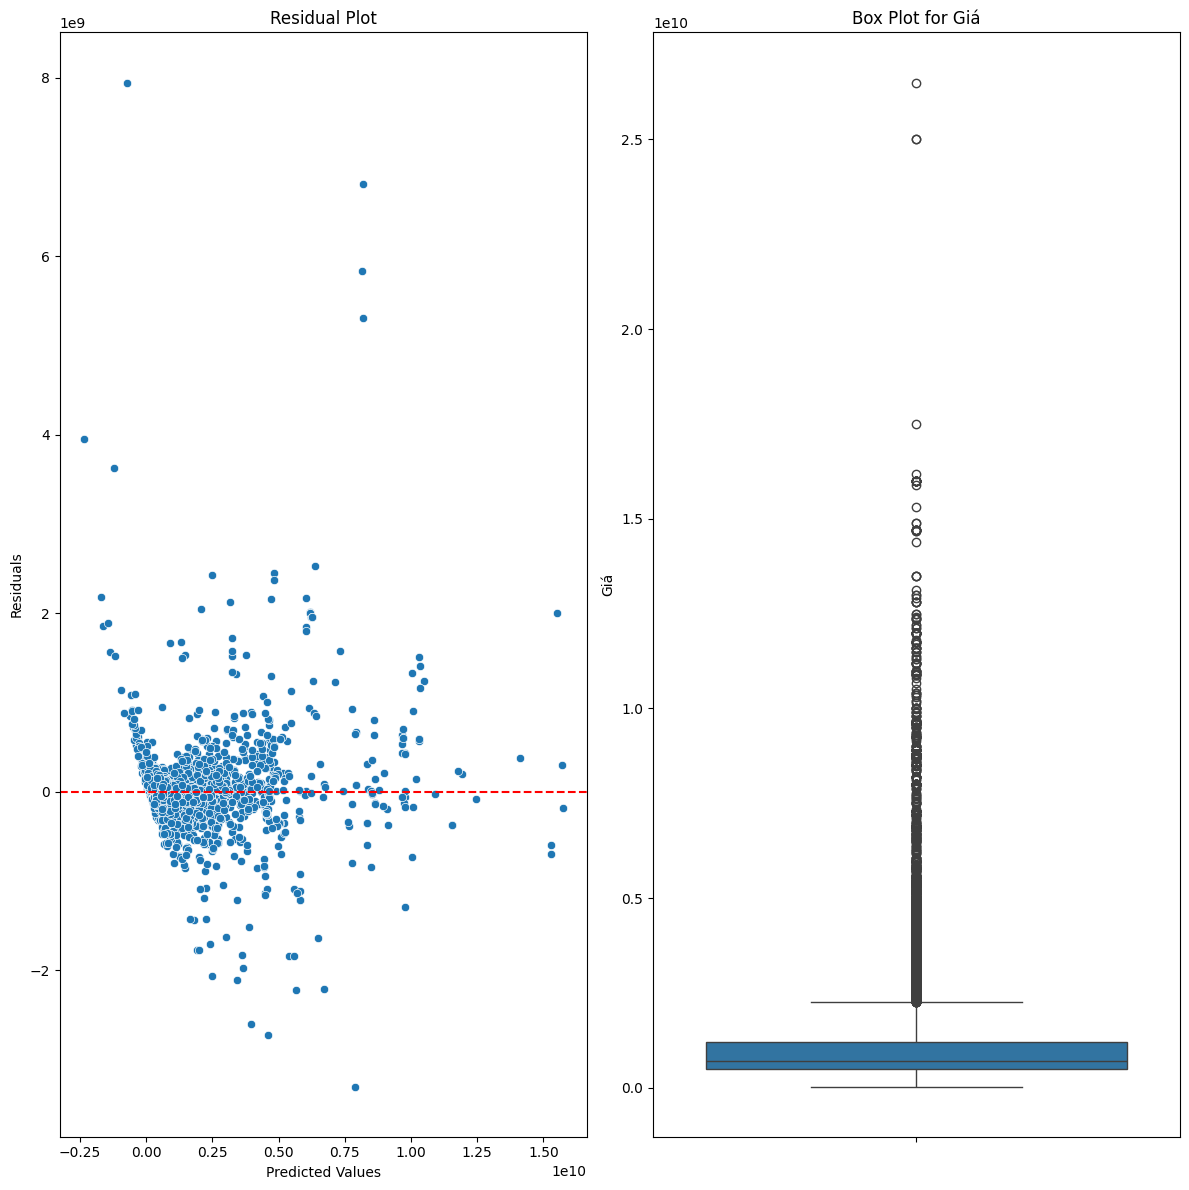

In [ ]:
# Create a 1x2 subplot grid
plt.figure(figsize=(12, 12))

# Subplot 1: Residual Plot
plt.subplot(1, 2, 1)
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Subplot 2: Box Plot for y_train
plt.subplot(1, 2, 2)
sns.boxplot(y=y_train)
plt.title('Box Plot for Giá')
plt.ylabel('Giá')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined Giá
plt.show()


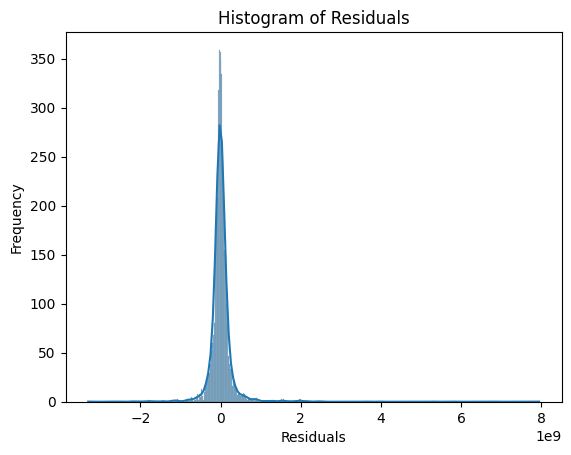

In [ ]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Multiple linear regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Khởi tạo mô hình Lasso Regression
model = Lasso()

# Định nghĩa các tham số cho việc tối ưu hóa
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# Thực hiện tối ưu hóa tham số sử dụng Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_concat, y_train)

# Lấy ra các tham số tốt nhất
best_parameters = grid_search.best_params_

# Huấn luyện mô hình với các tham số tốt nhất
model = Lasso(alpha=best_parameters['alpha'])
model.fit(X_train_concat, y_train)

# Dự đoán giá trị
y_pred = model.predict(X_test_concat)

# Tính toán Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# Tính toán Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Tính toán Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

# Tính toán R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.859e+20, tolerance: 4.446e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense nu

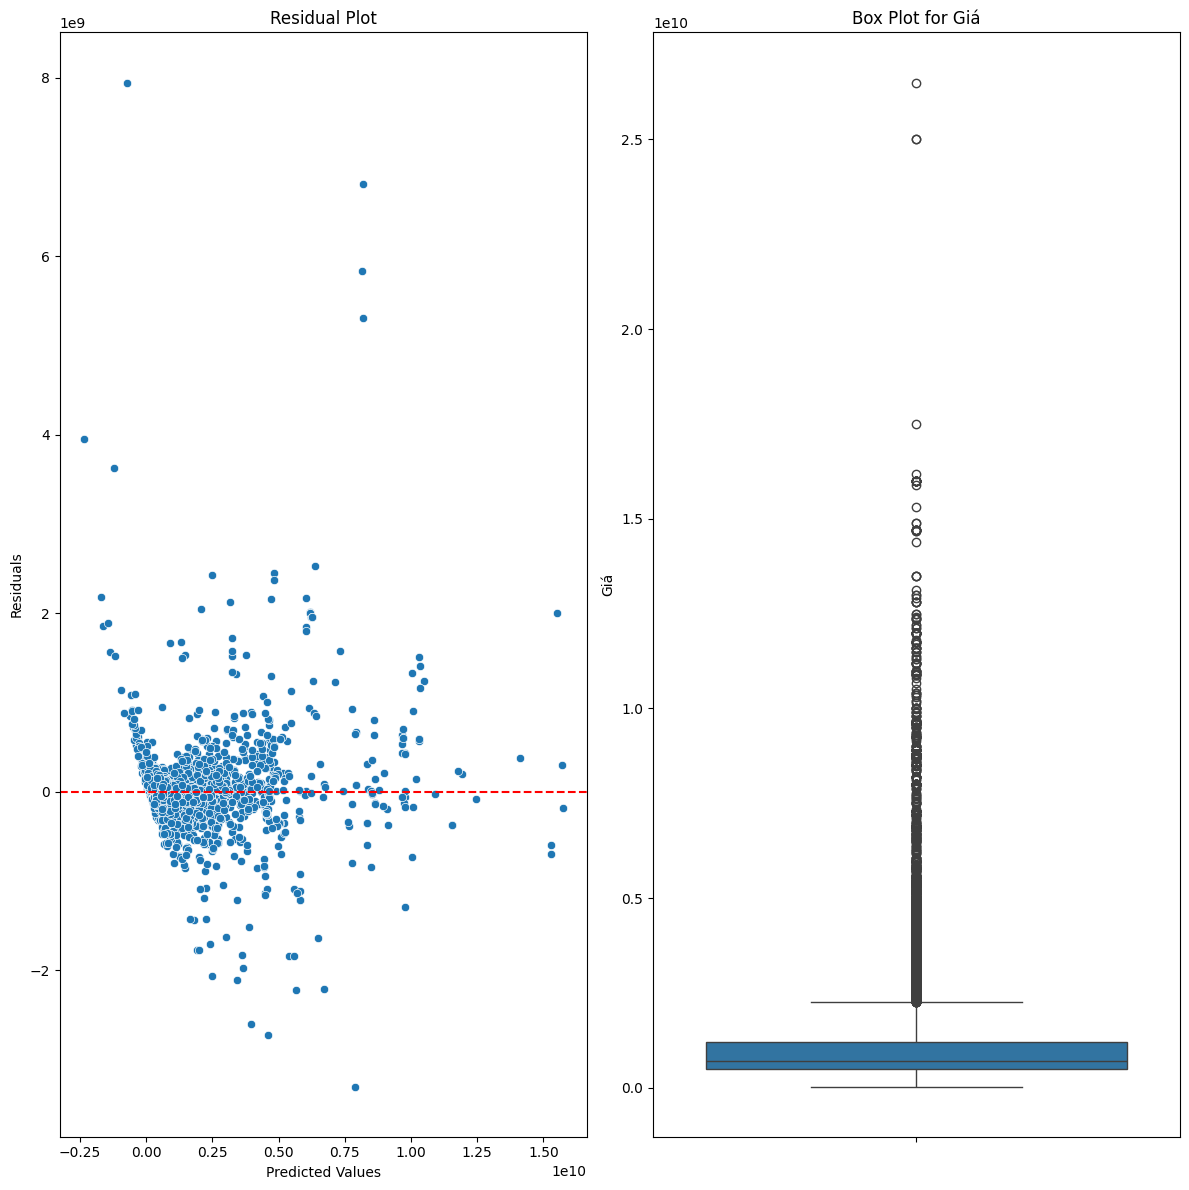

In [ ]:
# Create a 2x2 subplot grid
plt.figure(figsize=(12, 12))

# Subplot 1: Residual Plot
plt.subplot(2, 2, 1)
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Subplot 2: Box Plot for y_train
plt.subplot(2, 2, 2)
sns.boxplot(y=y_train)
plt.title('Box Plot for Giá')
plt.ylabel('Giá')

# Subplot 3: Scatter Plot of Actual vs Predicted Values
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plots
plt.show()

## KNN

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Apply PCA with arpack solver
pca = PCA(n_components=10, svd_solver='arpack')  # Specify the solver and choose a fixed number of components
X_train_pca = pca.fit_transform(X_train_concat)
X_test_pca = pca.transform(X_test_concat)

# Lists to store results
k_values = list(range(2, 9))
mse_values = []
r2_values = []
mae_values = []

for k in k_values:
    # Initialize the KNN regressor with the current k value
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    
    # Train the KNN model on the reduced data
    knn_regressor.fit(X_train_pca, y_train)

    # Make predictions on the reduced test data
    y_pred = knn_regressor.predict(X_test_pca)

    # Calculate MSE, R^2, and MAE for the current k value
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    mse_values.append(mse)
    r2_values.append(r2)
    mae_values.append(mae)

# Results
k_best_mse = k_values[np.argmin(mse_values)]
k_best_r2 = k_values[np.argmax(r2_values)]
k_best_mae = k_values[np.argmin(mae_values)]

print(f'Best k value for MSE: {k_best_mse}')
print(f'Best k value for R^2: {k_best_r2}')
print(f'Best k value for MAE: {k_best_mae}')


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
mse_values, r2_values, mae_values

([5.758265042491704e+17,
  5.7309222576272006e+17,
  6.172626367420746e+17,
  6.227078337788723e+17,
  6.688406638875812e+17,
  6.941289306185156e+17,
  7.246771759307619e+17],
 [0.7625569755652579,
  0.7636844598833272,
  0.7454707168616528,
  0.7432253807343305,
  0.7242024308945538,
  0.7137747717107603,
  0.7011781515402942],
 [210571431.77944806,
  235649267.0033194,
  256131654.54939988,
  269491477.3046663,
  283362971.4011367,
  294980097.7084661,
  307788059.9889664])

In [ ]:
print("Best k:", k_best_mae)

Best k: 2


### Giải thích

### Tổng quan

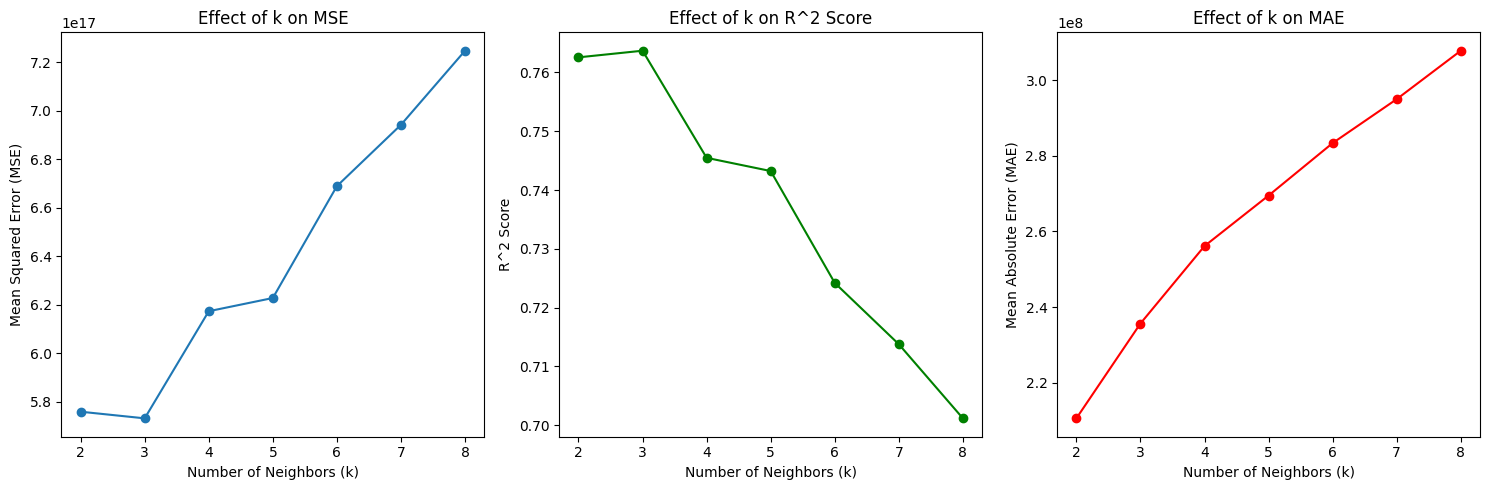

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 subplot grid
plt.figure(figsize=(20, 10))

# Subplot 1: Effect of k on MSE
plt.subplot(2, 2, 1)
plt.plot(k_values, mse_values, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Effect of k on MSE')

# Subplot 2: Effect of k on R^2 Score
plt.subplot(2, 2, 2)
plt.plot(k_values, r2_values, marker='o', linestyle='-', color='green')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('R^2 Score')
plt.title('Effect of k on R^2 Score')

# Subplot 3: Effect of k on MAE
plt.subplot(2, 2, 3)
plt.plot(k_values, mae_values, marker='o', linestyle='-', color='red')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Effect of k on MAE')

# Subplot 4: Scatter Plot of Actual vs Predicted Values
plt.subplot(2, 2, 4)
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plots
plt.show()


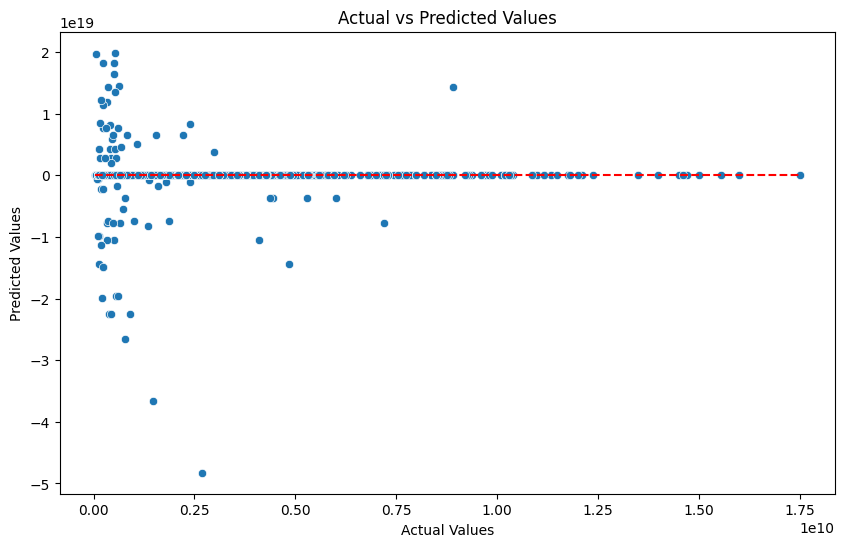

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Khởi tạo mô hình Decision Tree
model = DecisionTreeRegressor(random_state=0)

# Huấn luyện mô hình với tập dữ liệu huấn luyện
model.fit(X_train_concat, y_train)

# Dự đoán giá trị
y_pred = model.predict(X_test_concat)

# Tính toán Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# Tính toán Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Tính toán Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

# Tính toán R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


Mean Squared Error: 1.9111250065817997e+17
Mean Absolute Error: 114951786.07963888
R^2 Score: 0.9211944399420544


### Giải thích

### Visualization

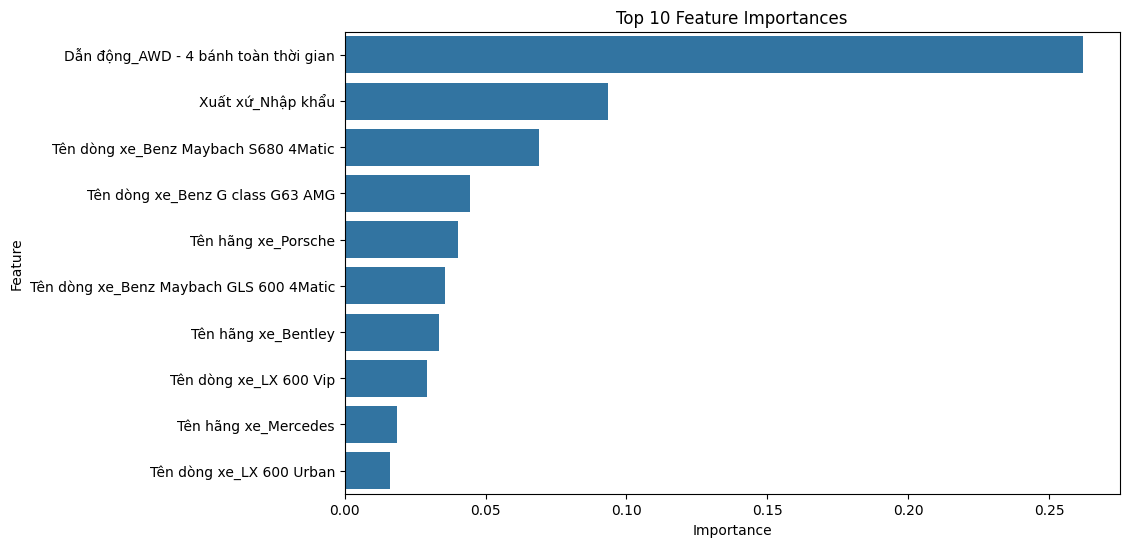

In [ ]:
feature_importances = dt_model.feature_importances_
feature_names = OH_encoder.get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

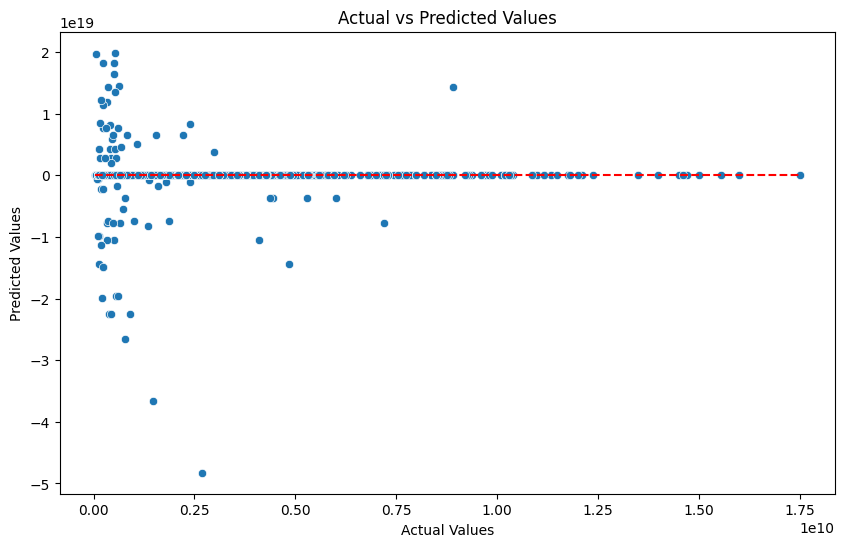

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

### Tổng kết

## Gradient Boosting Regression

In [ ]:
# Initialize the Gradient Boosting Regressor model
gbdt_model = GradientBoostingRegressor(random_state=42)

# Train the model on the transformed and encoded data
gbdt_model.fit(OH_X_train, y_train)

# Predictions on the test data
y_pred = gbdt_model.predict(OH_X_test)

# Calculate the MSE, R^2, and MAE metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 5.01200222405813e+17
R^2: 0.7933292479987941
Mean Absolute Error: 393294146.54886985


### Giải thích

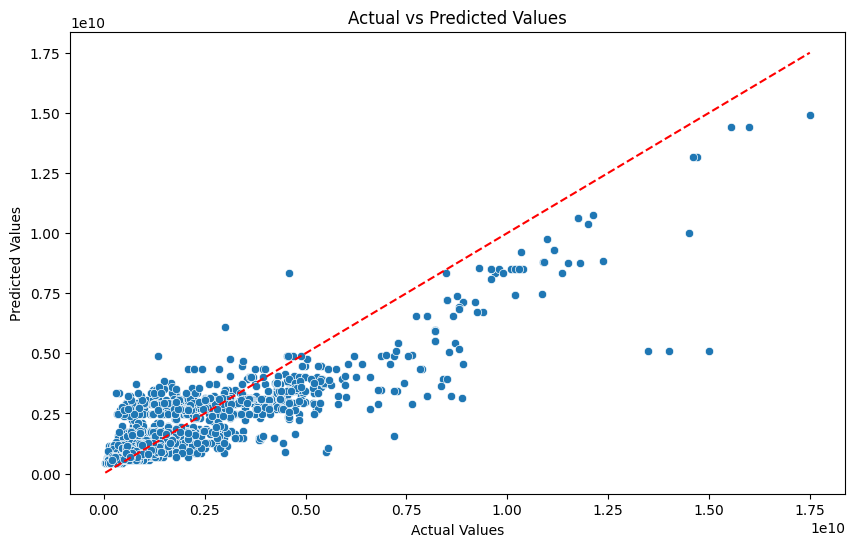

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

## Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize the Bagging Regressor model
bagging_model = BaggingRegressor(random_state=42)

# Train the model on the transformed and encoded data
bagging_model.fit(OH_X_train, y_train)

# Predictions on the test data
y_pred = bagging_model.predict(OH_X_test)

# Calculate the MSE, R^2, and MAE metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 1.2480713484118619e+17
R^2: 0.9485355687016058
Mean Absolute Error: 114912738.64501457


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score

# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Train each model and calculate its R^2 score
for model_name, model in models.items():
    model.fit(OH_X_train, y_train)
    y_pred = model.predict(OH_X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} R^2 Score: {r2}")


Linear Regression R^2 Score: 0.9453566766477666
Decision Tree R^2 Score: 0.9278513051212942
Random Forest R^2 Score: 0.9361769402364793
Gradient Boosting R^2 Score: 0.8081257997860168


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Add the new models to the dictionary
models.update({
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Machine": SVR(),
    "Multiple Linear Regression": LinearRegression()
})

# Train each model and calculate its R^2 score
for model_name, model in models.items():
    model.fit(OH_X_train, y_train)
    y_pred = model.predict(OH_X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} R^2 Score: {r2}")


Linear Regression R^2 Score: 0.9453566766477666
Decision Tree R^2 Score: 0.9278513051212942
Random Forest R^2 Score: 0.9361769402364793
Gradient Boosting R^2 Score: 0.8081257997860168
K-Nearest Neighbors R^2 Score: 0.8806484445784383
Support Vector Machine R^2 Score: -0.11382674069677168
Multiple Linear Regression R^2 Score: 0.9453566766477666
